In [1]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', 100)

#显示所有行

pd.set_option('display.max_rows', 100)

import warnings
warnings.filterwarnings("ignore")
import xgboost as xgb
from xgboost import plot_importance
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import numpy as np

import sys
import time
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import datetime
import warnings
import feather
warnings.filterwarnings("ignore")
import math
sys.path.append('/data/apps/modules/jupyter')
from helper.spark_helper import *
from helper.presto_helper import query_presto
from helper.csv_helper import *
from helper.pandas_helper import *
from helper.presto_helper import query_hive_wy

# 数据准备

In [3]:
'''
    松果特征
'''
citys='196'
sg_features = get_df_from_csv_table(query_presto(f'''
    select a.user_id, a.city_id, a.birthday, a.gender, b.model, b.brand, b.sys_ver,a.mobile
    from
    (select user_id, city_id, birthday, gender, mobile
    from dim.dim_user_info_df
    where city_id in ({citys})
    and gender!=0
    and birthday is not null
    and event_day='20210407') a left join
    (select user_id, model, brand, sys_ver
    from dws.dws_pt_user_action_da
    where event_day='20210407') b on a.user_id=b.user_id
'''))

In [2]:
'''
    极光特征
'''
jiguang_df=pd.read_csv('iaudience.csv').rename({'imei/phone/mac/imsi':'mobile'},axis=1)

In [5]:
sg_features['mobile']=sg_features['mobile'].astype('int')
merge_df=pd.merge(jiguang_df,sg_features,on='mobile',how='left')

In [9]:
'''
    用户偏好:最近30天内>5单
'''
user_pref_df = get_df_from_csv_table(query_presto(f'''
    select user_id, cur_date, order_days_30d,if(order_days_30d>5,1,0) as pref
    from dws.dws_pt_user_picture_da
    where city_id in ({citys}) and event_day='20210407'
''')).dropna()

In [8]:
user_pref_df.shape

(100989, 4)

In [11]:
merge_df.shape

(30132, 347)

In [10]:
user_pref_df[user_pref_df.pref==1].shape

(7741, 4)

In [99]:
train_df = pd.merge(merge_df,user_pref_df, on='user_id', how='left')

In [100]:
train_df[train_df.pref==1].shape

(3706, 350)

# 特征处理

In [101]:
import re
def edit_ver(x):
    try:
        if type(x)==type(0.1):
            return 'None'
        elif re.match('\d+\..*', x):
            return 'Android '+re.search('\d+', x)[0]
        elif re.match('Android \d+\..*', x):
            return 'Android '+re.search('\d+', x)[0]
        elif re.match('Android \d+$', x):
            return x
        elif re.match('iOS \d+$', x):
            return x
        elif re.match('iOS\d+\..*', x):
            return 'iOS '+re.search('\d+',x)[0]
        elif re.match('iOS \d+\..*', x):
            return 'iOS '+re.search('\d+',x)[0]
        elif re.match('\d+$', x):
            return 'Android '+x
        else:
            return 'Other'
    except:
        print(type(x))
def edit_encode(x):
    if len(x)<9:
        return 0
    else:
        return int(x[7:])  

In [102]:
train_df['sys_ver_edited'] = train_df.sys_ver.map(edit_ver)

In [103]:
train_df['sys_ver_edited'] = train_df.sys_ver_edited.map(edit_encode)

In [104]:
train_df['sys_ver_edited'] = train_df['sys_ver_edited'].astype('int')

In [105]:
train_df=train_df.fillna('None')

In [106]:
train_df[train_df.pref=="None"].shape

(214, 351)

In [107]:
train_df2=train_df[train_df.pref!="None"]

In [108]:
train_df2['birthyear'] = train_df2['birthday'].map(lambda x: int(x[:4]))

In [109]:
train_df2['pref']=train_df2['pref'].astype('int')
train_df2['gender']=train_df2['gender'].astype('float')

In [202]:
tmp_list=[   'brand',
              'model',
              'SOM_OCM_CAREER',
              'CPL_INDM_EDU_LEVEL',
              'CPL_INDM_MARRC2',
              'FIM_FISM_INCL',
              'FIM_FISM_CONL_CIR',
              ]
feature_list=['gender',
              'birthyear',
              'sys_ver_edited',
              'brand',
              'model',
              'SOM_OCM_CAREER',
              'CPL_INDM_EDU_LEVEL',
              'CPL_INDM_MARRC2',
              'FIM_FISM_INCL',
              'FIM_FISM_CONL_CIR',
              'pref'
              ]
col_new_feat=['gender',
             'birthyear',
             'SOM_OCM_CAREER_transformed',
             'CPL_INDM_EDU_LEVEL_transformed',
             'CPL_INDM_MARRC2_transformed',
             'FIM_FISM_INCL_transformed',
             'FIM_FISM_CONL_CIR_transformed',
#  'GBM_BHM_PURB_CONP_one_hot',
#  'GBM_BHM_PURB_PREF_transformed',
             'sys_ver_edited',
             'brand_transformed',
             'model_transformed'
             ]

In [111]:
train_df2=train_df2[feature_list]

In [112]:
from sklearn import preprocessing
lbl = preprocessing.LabelEncoder()
lis=[]
for col in tmp_list:
    try:
        train_df2[col+'_transformed'] = lbl.fit_transform(train_df2[col].astype('category'))
    except:
        lis.append(col)

In [113]:
train_df2

,gender,birthyear,sys_ver_edited,brand,model,SOM_OCM_CAREER,CPL_INDM_EDU_LEVEL,CPL_INDM_MARRC2,FIM_FISM_INCL,FIM_FISM_CONL_CIR,pref,brand_transformed,model_transformed,SOM_OCM_CAREER_transformed,CPL_INDM_EDU_LEVEL_transformed,CPL_INDM_MARRC2_transformed,FIM_FISM_INCL_transformed,FIM_FISM_CONL_CIR_transformed
0,2,1982,10,HUAWEI,STK-AL00,企业人员,高,已婚,低,中,0,13,728,4,3,1,2,1
1,2,1974,10,OPPO,PBET00,None,None,None,None,None,0,26,508,1,0,0,0,0
2,2,1997,10,vivo,V2002A,None,None,None,None,None,0,51,807,1,0,0,0,0
3,2,1977,10,vivo,V2031A,企业人员,中,已婚,None,None,0,51,816,4,1,1,0,0
4,2,1998,9,vivo,V1831A,白领,高,未婚,低,低,0,51,770,18,3,2,2,2
5,1,1973,8,OPPO,PBAM00,企业人员,低,未婚,中,低,0,26,496,4,2,2,1,2
6,2,2000,7,vivo,vivo Y79,None,None,None,None,None,1,51,926,1,0,0,0,0
7,2,1992,10,OnePlus,ONEPLUS%20A6000,None,低,已婚,None,None,0,27,413,1,2,1,0,0
8,1,1993,5,OPPO,OPPO%20R9%20Plusm%20A,None,None,None,None,None,0,26,469,1,0,0,0,0
9,1,1991,9,meizu,Note9,None,None,None,None,None,0,46,400,1,0,0,0,0


In [230]:
# train_df['brand'].value_counts()

# 模型训练

In [139]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import HuberRegressor, LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.kernel_ridge import KernelRidge
import xgboost as xgb
from xgboost import plot_importance, XGBClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
temp=train_df2

col_feature = col_new_feat


col_label = 'pref'

kf = KFold(n_splits=5,shuffle=True)
r0 = []
r1 = []
m0 = []
m1 = []
f = 0
# citys = list(temp.city_id.unique())

# for train_index, test_index in kf.split(temp):
# f+=1
# train = temp.iloc[train_index]
# test = temp.iloc[test_index]

train_X,test_X,train_y,test_y =train_test_split(temp[col_feature],temp[col_label],test_size=0.25)


params = {
    'booster': 'gbtree',          #使用不同的booster
    'objective': 'binary:logistic', 
        'gamma': 0.1,             #默认0，min_split_loss 树的叶节点进一步分区所需最小损失 [0,∞]
    'max_depth': 5,               #默认6 一棵树的最大深度，越大越易过拟合   [0,∞]
        'reg_lambda': 10,         #默认1 L2正则项，越大模型越保守
    'subsample': 0.6,             #默认1 训练实例的子样本比例  0.5意味着XGBoost将在树木生长之前随机采样一半的训练数据,可防止过拟合 (0,1]
    'colsample_bytree': 0.6,      #默认1 用于列二次采样的参数  (0,1]
    'min_child_weight': 1,        #默认1 子级中实例重量的最小总和（hessian）。越大算法将越保守。 [0,∞]
    'eta': 0.01,                  #默认0.3 学习率   [0,1]
    'seed': 1000,
    'nthread': 4,
     'eval_metric':['auc','error'],
#     'alpha': 5
}

dtrain = xgb.DMatrix(train_X, train_y)
dtest = xgb.DMatrix(test_X, test_y)
num_rounds = 100
plst = params.items()
#model = XGBClassifier(params)
model=xgb.train(params, dtrain, num_rounds, [(dtest, 'eval'), (dtrain,'train')])
#model.fit(X, y, early_stopping_rounds=20, eval_metric="auc", eval_set=[(test[col_feat],test[col_ans])], verbose=True)
#pred = model.predict(test[col_feat])
#pred = [round(value) for value in pred]
#     accuracy = accuracy_score(test[col_ans], pred)
#     print("Accuracy: %.2f%%" % (accuracy * 100.0))
    

[0]	eval-auc:0.50000	eval-error:0.12473	train-auc:0.50000	train-error:0.12359
[1]	eval-auc:0.55597	eval-error:0.12473	train-auc:0.54835	train-error:0.12359
[2]	eval-auc:0.56137	eval-error:0.12473	train-auc:0.55608	train-error:0.12359
[3]	eval-auc:0.56861	eval-error:0.12473	train-auc:0.56396	train-error:0.12359
[4]	eval-auc:0.56861	eval-error:0.12473	train-auc:0.56396	train-error:0.12359
[5]	eval-auc:0.56738	eval-error:0.12473	train-auc:0.56449	train-error:0.12359
[6]	eval-auc:0.56415	eval-error:0.12473	train-auc:0.56283	train-error:0.12359
[7]	eval-auc:0.57001	eval-error:0.12473	train-auc:0.56565	train-error:0.12359
[8]	eval-auc:0.56954	eval-error:0.12473	train-auc:0.56584	train-error:0.12359
[9]	eval-auc:0.57175	eval-error:0.12473	train-auc:0.57132	train-error:0.12359
[10]	eval-auc:0.59728	eval-error:0.12473	train-auc:0.59432	train-error:0.12359
[11]	eval-auc:0.59930	eval-error:0.12473	train-auc:0.59656	train-error:0.12359
[12]	eval-auc:0.59930	eval-error:0.12473	train-auc:0.59656	tra

# 增加特征

In [ ]:
APP_HOBY_SHORT_VIDEO : 17156
APP_HOBY_SUMMARY_VIDEO : 18616
APP_HOBY_SELF_PHOTO : 18766
APP_HOBY_SUNMMARY_NEWS : 12121
APP_HOBY_SPEED_GAME : 9683
APP_HOBY_WIFI : 14995
APP_HOBY_FOOD : 11216
APP_HOBY_RECORD : 13245
APP_HOBY_HOT_SOCIAL : 19412
APP_HOBY_ONLINE_STUDY : 7306
APP_HOBY_ZONGHE_SHOPPING : 16659
APP_HOBY_DISCOUNT_MARKET : 7769
APP_HOBY_GROUP_BUY : 8303
APP_HOBY_SMOTE_OFFICE : 17981

In [187]:
feature_add_list=[
'APP_HOBY_SHORT_VIDEO',
'APP_HOBY_SUMMARY_VIDEO' ,
'APP_HOBY_SELF_PHOTO' ,
'APP_HOBY_SUNMMARY_NEWS' ,
'APP_HOBY_SPEED_GAME',
'APP_HOBY_WIFI',
'APP_HOBY_FOOD',
'APP_HOBY_RECORD',
'APP_HOBY_HOT_SOCIAL' ,
'APP_HOBY_ONLINE_STUDY' ,
'APP_HOBY_ZONGHE_SHOPPING' ,
'APP_HOBY_DISCOUNT_MARKET' ,
'APP_HOBY_GROUP_BUY' ,
'APP_HOBY_SMOTE_OFFICE'
                 ]

In [165]:
import re
def edit_app_hoby(x):
    if x=="None":
        return 0
    else:
        return float(re.findall(r'\d+\.\d+',x)[0])

In [ ]:
train_df['APP_HOBY_SHORT_VIDEO']=train_df.APP_HOBY_SHORT_VIDEO.map(edit_app_hoby)
train_df['APP_HOBY_SUMMARY_VIDEO']=train_df.APP_HOBY_SUMMARY_VIDEO.map(edit_app_hoby)
train_df['APP_HOBY_SELF_PHOTO']=train_df.APP_HOBY_SELF_PHOTO.map(edit_app_hoby)
train_df['APP_HOBY_SUNMMARY_NEWS']=train_df.APP_HOBY_SUNMMARY_NEWS.map(edit_app_hoby)
train_df['APP_HOBY_SPEED_GAME']=train_df.APP_HOBY_SPEED_GAME.map(edit_app_hoby)
train_df['APP_HOBY_WIFI']=train_df.APP_HOBY_WIFI.map(edit_app_hoby)
train_df['APP_HOBY_FOOD']=train_df.APP_HOBY_FOOD.map(edit_app_hoby)
train_df['APP_HOBY_RECORD']=train_df.APP_HOBY_RECORD.map(edit_app_hoby)
train_df['APP_HOBY_HOT_SOCIAL']=train_df.APP_HOBY_HOT_SOCIAL.map(edit_app_hoby)
train_df['APP_HOBY_ONLINE_STUDY']=train_df.APP_HOBY_ONLINE_STUDY.map(edit_app_hoby)
train_df['APP_HOBY_HOT_SOCIAL']=train_df.APP_HOBY_HOT_SOCIAL.map(edit_app_hoby)
train_df['APP_HOBY_ONLINE_STUDY']=train_df.APP_HOBY_ONLINE_STUDY.map(edit_app_hoby)

In [174]:
train_df['APP_HOBY_ZONGHE_SHOPPING']=train_df.APP_HOBY_ZONGHE_SHOPPING.map(edit_app_hoby)
train_df['APP_HOBY_DISCOUNT_MARKET']=train_df.APP_HOBY_DISCOUNT_MARKET.map(edit_app_hoby)
train_df['APP_HOBY_GROUP_BUY']=train_df.APP_HOBY_GROUP_BUY.map(edit_app_hoby)
train_df['APP_HOBY_SMOTE_OFFICE']=train_df.APP_HOBY_SMOTE_OFFICE.map(edit_app_hoby)

In [175]:
train_df3=train_df[train_df.pref!="None"]
train_df3['birthyear'] = train_df3['birthday'].map(lambda x: int(x[:4]))
train_df3['pref']=train_df3['pref'].astype('int')
train_df3['gender']=train_df3['gender'].astype('float')
from sklearn import preprocessing
lbl = preprocessing.LabelEncoder()
lis=[]
for col in tmp_list:
    try:
        train_df3[col+'_transformed'] = lbl.fit_transform(train_df3[col].astype('category'))
    except:
        lis.append(col)

In [214]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import HuberRegressor, LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.kernel_ridge import KernelRidge
import xgboost as xgb
from xgboost import plot_importance, XGBClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
temp=train_df3

col_feature = col_new_feat+feature_add_list


col_label = 'pref'

kf = KFold(n_splits=5,shuffle=True)
r0 = []
r1 = []
m0 = []
m1 = []
f = 0
# citys = list(temp.city_id.unique())

# for train_index, test_index in kf.split(temp):
# f+=1
# train = temp.iloc[train_index]
# test = temp.iloc[test_index]

train_X,test_X,train_y,test_y =train_test_split(temp[col_feature],temp[col_label],test_size=0.3)


params = {
    'booster': 'gbtree',          #使用不同的booster
    'objective': 'binary:logistic', 
        'gamma': 0.1,             #默认0，min_split_loss 树的叶节点进一步分区所需最小损失 [0,∞]
    'max_depth': 5,               #默认6 一棵树的最大深度，越大越易过拟合   [0,∞]
        'reg_lambda': 10,         #默认1 L2正则项，越大模型越保守
    'subsample': 0.6,             #默认1 训练实例的子样本比例  0.5意味着XGBoost将在树木生长之前随机采样一半的训练数据,可防止过拟合 (0,1]
    'colsample_bytree': 0.6,      #默认1 用于列二次采样的参数  (0,1]
    'min_child_weight': 1,        #默认1 子级中实例重量的最小总和（hessian）。越大算法将越保守。 [0,∞]
    'eta': 0.01,                  #默认0.3 学习率   [0,1]
    'seed': 1000,
    'nthread': 4,
     'eval_metric':['auc','error'],
#     'alpha': 5
}

dtrain = xgb.DMatrix(train_X, train_y)
dtest = xgb.DMatrix(test_X, test_y)
num_rounds = 150
plst = params.items()
#model = XGBClassifier(params)
model=xgb.train(params, dtrain, num_rounds, [(dtest, 'eval'), (dtrain,'train')])
#model.fit(X, y, early_stopping_rounds=20, eval_metric="auc", eval_set=[(test[col_feat],test[col_ans])], verbose=True)
#pred = model.predict(test[col_feat])
#pred = [round(value) for value in pred]
#     accuracy = accuracy_score(test[col_ans], pred)
#     print("Accuracy: %.2f%%" % (accuracy * 100.0))
    

[0]	eval-auc:0.55758	eval-error:0.12032	train-auc:0.55454	train-error:0.12587
[1]	eval-auc:0.56187	eval-error:0.11943	train-auc:0.56620	train-error:0.12563
[2]	eval-auc:0.56236	eval-error:0.11943	train-auc:0.57521	train-error:0.12573
[3]	eval-auc:0.56340	eval-error:0.11943	train-auc:0.57665	train-error:0.12568
[4]	eval-auc:0.58488	eval-error:0.11943	train-auc:0.59728	train-error:0.12573
[5]	eval-auc:0.58434	eval-error:0.11943	train-auc:0.59703	train-error:0.12573
[6]	eval-auc:0.59129	eval-error:0.11943	train-auc:0.60019	train-error:0.12573
[7]	eval-auc:0.59941	eval-error:0.11943	train-auc:0.60808	train-error:0.12573
[8]	eval-auc:0.59985	eval-error:0.11943	train-auc:0.60867	train-error:0.12573
[9]	eval-auc:0.59971	eval-error:0.11943	train-auc:0.60864	train-error:0.12573
[10]	eval-auc:0.60337	eval-error:0.11943	train-auc:0.61073	train-error:0.12573
[11]	eval-auc:0.60259	eval-error:0.11943	train-auc:0.61043	train-error:0.12573
[12]	eval-auc:0.60276	eval-error:0.11943	train-auc:0.60979	tra

[104]	eval-auc:0.60886	eval-error:0.11943	train-auc:0.63227	train-error:0.12578
[105]	eval-auc:0.60898	eval-error:0.11943	train-auc:0.63231	train-error:0.12578
[106]	eval-auc:0.60956	eval-error:0.11943	train-auc:0.63278	train-error:0.12578
[107]	eval-auc:0.60950	eval-error:0.11943	train-auc:0.63318	train-error:0.12578
[108]	eval-auc:0.60961	eval-error:0.11943	train-auc:0.63362	train-error:0.12578
[109]	eval-auc:0.61029	eval-error:0.11943	train-auc:0.63376	train-error:0.12578
[110]	eval-auc:0.61031	eval-error:0.11943	train-auc:0.63381	train-error:0.12578
[111]	eval-auc:0.61043	eval-error:0.11943	train-auc:0.63419	train-error:0.12578
[112]	eval-auc:0.61080	eval-error:0.11943	train-auc:0.63445	train-error:0.12578
[113]	eval-auc:0.61097	eval-error:0.11943	train-auc:0.63501	train-error:0.12578
[114]	eval-auc:0.61131	eval-error:0.11943	train-auc:0.63507	train-error:0.12578
[115]	eval-auc:0.61118	eval-error:0.11943	train-auc:0.63502	train-error:0.12578
[116]	eval-auc:0.61100	eval-error:0.1194

# hyperopt 调参

In [208]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
continus_cols = ['APP_HOBY_SHORT_VIDEO',
                'APP_HOBY_SUMMARY_VIDEO' ,
                'APP_HOBY_SELF_PHOTO' ,
                'APP_HOBY_SUNMMARY_NEWS' ,
                'APP_HOBY_SPEED_GAME',
                'APP_HOBY_WIFI',
                'APP_HOBY_FOOD',
                'APP_HOBY_RECORD',
                'APP_HOBY_HOT_SOCIAL' ,
                'APP_HOBY_ONLINE_STUDY' ,
                'APP_HOBY_ZONGHE_SHOPPING' ,
                'APP_HOBY_DISCOUNT_MARKET' ,
                'APP_HOBY_GROUP_BUY' ,
                'APP_HOBY_SMOTE_OFFICE']

category_cols = ["gender", "birthyear","SOM_OCM_CAREER_transformed", "CPL_INDM_EDU_LEVEL_transformed",
                 "CPL_INDM_MARRC2_transformed",    
                 "FIM_FISM_INCL_transformed", 
                 'sys_ver_edited',
                'brand_transformed',
                 'model_transformed']
preprocessor = ColumnTransformer(
                 transformers=[
                     ("none", FunctionTransformer(lambda x: x), continus_cols), 
                    ("onehot", OneHotEncoder(handle_unknown='ignore'), category_cols)
                    ])

train = preprocessor.fit_transform(train_df3[category_cols+continus_cols])
train_y = train_df3[col_label].tolist()




In [211]:
import hyperopt 
def hyperopt_objective(params):
    

    model = XGBClassifier(
        objective= 'binary:logistic',
        max_depth=int(params['max_depth']) + 3,
        learning_rate=params['learning_rate'],
        n_estimators=int(params['n_estimators']),
        min_child_weight=int(params['min_child_weight']),
        subsample=params["subsample"],
        colsample_bytree=params["colsample_bytree"],
        gamma=params["gamma"]

    )
     
    res = np.mean(cross_val_score(model, train, train_y, cv=5, n_jobs=-1, scoring='roc_auc'))
    print("*" * 30)
    print(params)
    print("roc_auc: {}".format(res))
    
    return 1 - res
params_space = {

    'max_depth': hyperopt.hp.randint('max_depth',3, 10),
    'learning_rate': hyperopt.hp.uniform('learning_rate', 1e-3, 3e-1),
    'n_estimators': hyperopt.hp.quniform("n_estimators", 100, 200, 10),
    'min_child_weight': hyperopt.hp.randint('min_child_weight', 3),
    'subsample': hyperopt.hp.uniform('subsample', 0.6, 1),
    'colsample_bytree': hyperopt.hp.uniform('colsample_bytree', 0.6, 1),
    'gamma': hyperopt.hp.uniform('gamma', 0, 0.3)
}
trials = hyperopt.Trials()
best = hyperopt.fmin(
    hyperopt_objective,
    space=params_space,
    algo=hyperopt.tpe.suggest,
    max_evals=20,
    trials=trials)

print("最佳参数")
print(best)

******************************                        
{'colsample_bytree': 0.752062269145793, 'learning_rate': 0.23917158946013717, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 180.0, 'subsample': 0.6595937687904329}
roc_auc: 0.5655677266036889                           
******************************                                                  
{'colsample_bytree': 0.9569553401580937, 'learning_rate': 0.15054118894132765, 'max_depth': 7, 'min_child_weight': 2, 'n_estimators': 180.0, 'subsample': 0.6874452119969431}
roc_auc: 0.5656322881347027                                                     
******************************                                                  
{'colsample_bytree': 0.9654793108914872, 'learning_rate': 0.23851410675093446, 'max_depth': 9, 'min_child_weight': 0, 'n_estimators': 120.0, 'subsample': 0.7754554937746468}
roc_auc: 0.5545492361751803                                                     
******************************               

# 过滤极光未查询到数据

In [233]:
def edit_query_result(x):
    if x=='查询标签成功-有标签':
        return 1
    else:
        return 0

In [237]:
train_df4= train_df[train_df.pref!="None"]

In [238]:
train_df4['query_result']=train_df4.查询结果.map(edit_query_result)

In [239]:
train_df4=train_df4[train_df4.query_result==1]

In [242]:
train_df4[train_df4.pref==1].shape

(3097, 360)

In [240]:
train_df4['birthyear'] = train_df4['birthday'].map(lambda x: int(x[:4]))
train_df4['pref']=train_df4['pref'].astype('int')
train_df4['gender']=train_df4['gender'].astype('float')
from sklearn import preprocessing
lbl = preprocessing.LabelEncoder()
lis=[]
for col in tmp_list:
    try:
        train_df4[col+'_transformed'] = lbl.fit_transform(train_df4[col].astype('category'))
    except:
        lis.append(col)

In [245]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import HuberRegressor, LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.kernel_ridge import KernelRidge
import xgboost as xgb
from xgboost import plot_importance, XGBClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
temp=train_df4

col_feature = col_new_feat+feature_add_list


col_label = 'pref'

kf = KFold(n_splits=5,shuffle=True)
r0 = []
r1 = []
m0 = []
m1 = []
f = 0
# citys = list(temp.city_id.unique())

# for train_index, test_index in kf.split(temp):
# f+=1
# train = temp.iloc[train_index]
# test = temp.iloc[test_index]

train_X,test_X,train_y,test_y =train_test_split(temp[col_feature],temp[col_label],test_size=0.3)


params = {
    'booster': 'gbtree',          #使用不同的booster
    'objective': 'binary:logistic', 
        'gamma': 0.1,             #默认0，min_split_loss 树的叶节点进一步分区所需最小损失 [0,∞]
    'max_depth': 5,               #默认6 一棵树的最大深度，越大越易过拟合   [0,∞]
        'reg_lambda': 10,         #默认1 L2正则项，越大模型越保守
    'subsample': 0.6,             #默认1 训练实例的子样本比例  0.5意味着XGBoost将在树木生长之前随机采样一半的训练数据,可防止过拟合 (0,1]
    'colsample_bytree': 0.6,      #默认1 用于列二次采样的参数  (0,1]
    'min_child_weight': 1,        #默认1 子级中实例重量的最小总和（hessian）。越大算法将越保守。 [0,∞]
    'eta': 0.01,                  #默认0.3 学习率   [0,1]
    'seed': 1000,
    'nthread': 4,
     'eval_metric':['auc','error'],
#     'alpha': 5
}

dtrain = xgb.DMatrix(train_X, train_y)
dtest = xgb.DMatrix(test_X, test_y)
num_rounds = 150
plst = params.items()
#model = XGBClassifier(params)
model=xgb.train(params, dtrain, num_rounds, [(dtest, 'eval'), (dtrain,'train')])
#model.fit(X, y, early_stopping_rounds=20, eval_metric="auc", eval_set=[(test[col_feat],test[col_ans])], verbose=True)
#pred = model.predict(test[col_feat])
#pred = [round(value) for value in pred]
#     accuracy = accuracy_score(test[col_ans], pred)
#     print("Accuracy: %.2f%%" % (accuracy * 100.0))
    

[0]	eval-auc:0.49946	eval-error:0.12420	train-auc:0.50254	train-error:0.12643
[1]	eval-auc:0.54976	eval-error:0.12420	train-auc:0.55083	train-error:0.12660
[2]	eval-auc:0.56288	eval-error:0.12393	train-auc:0.56462	train-error:0.12666
[3]	eval-auc:0.56288	eval-error:0.12393	train-auc:0.56462	train-error:0.12666
[4]	eval-auc:0.56520	eval-error:0.12393	train-auc:0.56509	train-error:0.12666
[5]	eval-auc:0.56520	eval-error:0.12393	train-auc:0.56509	train-error:0.12666
[6]	eval-auc:0.56609	eval-error:0.12393	train-auc:0.56479	train-error:0.12666
[7]	eval-auc:0.56709	eval-error:0.12393	train-auc:0.56495	train-error:0.12666
[8]	eval-auc:0.56769	eval-error:0.12393	train-auc:0.56499	train-error:0.12666
[9]	eval-auc:0.56667	eval-error:0.12393	train-auc:0.56668	train-error:0.12666
[10]	eval-auc:0.57205	eval-error:0.12393	train-auc:0.57574	train-error:0.12666
[11]	eval-auc:0.57152	eval-error:0.12393	train-auc:0.57643	train-error:0.12666
[12]	eval-auc:0.57804	eval-error:0.12393	train-auc:0.58398	tra

[104]	eval-auc:0.61060	eval-error:0.12393	train-auc:0.63907	train-error:0.12666
[105]	eval-auc:0.61076	eval-error:0.12393	train-auc:0.63980	train-error:0.12666
[106]	eval-auc:0.61066	eval-error:0.12393	train-auc:0.63979	train-error:0.12666
[107]	eval-auc:0.61097	eval-error:0.12393	train-auc:0.64009	train-error:0.12666
[108]	eval-auc:0.61126	eval-error:0.12393	train-auc:0.64007	train-error:0.12666
[109]	eval-auc:0.61130	eval-error:0.12393	train-auc:0.64065	train-error:0.12666
[110]	eval-auc:0.61154	eval-error:0.12393	train-auc:0.64054	train-error:0.12666
[111]	eval-auc:0.61166	eval-error:0.12393	train-auc:0.64044	train-error:0.12666
[112]	eval-auc:0.61200	eval-error:0.12393	train-auc:0.64078	train-error:0.12666
[113]	eval-auc:0.61204	eval-error:0.12393	train-auc:0.64124	train-error:0.12666
[114]	eval-auc:0.61226	eval-error:0.12393	train-auc:0.64126	train-error:0.12666
[115]	eval-auc:0.61264	eval-error:0.12393	train-auc:0.64157	train-error:0.12666
[116]	eval-auc:0.61271	eval-error:0.1239

# 继续调参

In [246]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
continus_cols = ['APP_HOBY_SHORT_VIDEO',
                'APP_HOBY_SUMMARY_VIDEO' ,
                'APP_HOBY_SELF_PHOTO' ,
                'APP_HOBY_SUNMMARY_NEWS' ,
                'APP_HOBY_SPEED_GAME',
                'APP_HOBY_WIFI',
                'APP_HOBY_FOOD',
                'APP_HOBY_RECORD',
                'APP_HOBY_HOT_SOCIAL' ,
                'APP_HOBY_ONLINE_STUDY' ,
                'APP_HOBY_ZONGHE_SHOPPING' ,
                'APP_HOBY_DISCOUNT_MARKET' ,
                'APP_HOBY_GROUP_BUY' ,
                'APP_HOBY_SMOTE_OFFICE']

category_cols = ["gender", "birthyear","SOM_OCM_CAREER_transformed", "CPL_INDM_EDU_LEVEL_transformed",
                 "CPL_INDM_MARRC2_transformed",    
                 "FIM_FISM_INCL_transformed", 
                 'sys_ver_edited',
                'brand_transformed',
                 'model_transformed']
preprocessor = ColumnTransformer(
                 transformers=[
                     ("none", FunctionTransformer(lambda x: x), continus_cols), 
                    ("onehot", OneHotEncoder(handle_unknown='ignore'), category_cols)
                    ])

train = preprocessor.fit_transform(train_df4[category_cols+continus_cols])
train_y = train_df4[col_label].tolist()

In [262]:
import hyperopt 
auc_list=[]
def hyperopt_objective(params):
    

    model = XGBClassifier(
        objective= 'binary:logistic',
        max_depth=int(params['max_depth']) + 3,
        learning_rate=params['learning_rate'],
        n_estimators=int(params['n_estimators']),
        min_child_weight=int(params['min_child_weight']),
        subsample=params["subsample"],
        colsample_bytree=params["colsample_bytree"],
        gamma=params["gamma"]

    )
     
    res = np.mean(cross_val_score(model,train_df4[col_feature], train_df4['pref'], cv=5, n_jobs=-1, scoring='roc_auc'))
    print("*" * 30)
    print(params)
    print("roc_auc: {}".format(res))
    auc_list.append(res)
    return 1 - res
params_space = {

    'max_depth': hyperopt.hp.randint('max_depth',3, 10),
    'learning_rate': hyperopt.hp.uniform('learning_rate', 1e-3, 3e-1),
    'n_estimators': hyperopt.hp.quniform("n_estimators", 100, 200, 10),
    'min_child_weight': hyperopt.hp.randint('min_child_weight', 5),
    'subsample': hyperopt.hp.uniform('subsample', 0.6, 1),
    'colsample_bytree': hyperopt.hp.uniform('colsample_bytree', 0.6, 1),
    'gamma': hyperopt.hp.uniform('gamma', 0, 0.3)
}
trials = hyperopt.Trials()
best = hyperopt.fmin(
    hyperopt_objective,
    space=params_space,
    algo=hyperopt.tpe.suggest,
    max_evals=200,
    trials=trials)

print("最佳参数")
print(best,"roc_auc: {}".format(max(auc_list)))

******************************                         
{'colsample_bytree': 0.8793457962623448, 'gamma': 0.05392771518341006, 'learning_rate': 0.1556221592411159, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200.0, 'subsample': 0.9502713195190906}
roc_auc: 0.5778542346268924                            
******************************                                                    
{'colsample_bytree': 0.9961200317905822, 'gamma': 0.0891386367433979, 'learning_rate': 0.05925113751444275, 'max_depth': 7, 'min_child_weight': 2, 'n_estimators': 170.0, 'subsample': 0.9671481596153216}
roc_auc: 0.586859678854569                                                        
******************************                                                    
{'colsample_bytree': 0.9952874835875527, 'gamma': 0.22558145735989332, 'learning_rate': 0.16481374178696234, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 190.0, 'subsample': 0.6012458833479216}
roc_auc: 0.5551501958925343  

{'colsample_bytree': 0.961383270946089, 'gamma': 0.12099240941722102, 'learning_rate': 0.018173206925551598, 'max_depth': 4, 'min_child_weight': 0, 'n_estimators': 130.0, 'subsample': 0.6251927891759667}
roc_auc: 0.6111921976231184                                                        
******************************                                                     
{'colsample_bytree': 0.9301279226811272, 'gamma': 0.14639392194520148, 'learning_rate': 0.007870657294137065, 'max_depth': 4, 'min_child_weight': 0, 'n_estimators': 130.0, 'subsample': 0.770061066427903}
roc_auc: 0.6093915651680379                                                        
******************************                                                     
{'colsample_bytree': 0.9688052546261187, 'gamma': 0.21153193760835437, 'learning_rate': 0.2580205080062224, 'max_depth': 9, 'min_child_weight': 0, 'n_estimators': 110.0, 'subsample': 0.6609014674616182}
roc_auc: 0.5492845589798647                          

{'colsample_bytree': 0.7771524481504382, 'gamma': 0.2987940007910181, 'learning_rate': 0.058800020282014545, 'max_depth': 7, 'min_child_weight': 0, 'n_estimators': 150.0, 'subsample': 0.8498499909927594}
roc_auc: 0.5854101951332671                                                       
******************************                                                    
{'colsample_bytree': 0.8545755936505576, 'gamma': 0.2596228215796091, 'learning_rate': 0.03384262614226023, 'max_depth': 6, 'min_child_weight': 2, 'n_estimators': 170.0, 'subsample': 0.9697859932691228}
roc_auc: 0.5966047146760284                                                       
******************************                                                    
{'colsample_bytree': 0.9175394922905165, 'gamma': 0.23546796021097707, 'learning_rate': 0.1808966266377326, 'max_depth': 9, 'min_child_weight': 4, 'n_estimators': 160.0, 'subsample': 0.7412963096907002}
roc_auc: 0.5568162762675517                               

{'colsample_bytree': 0.9170401988746287, 'gamma': 0.0806667427594892, 'learning_rate': 0.06584053900990743, 'max_depth': 4, 'min_child_weight': 0, 'n_estimators': 120.0, 'subsample': 0.8904676331426554}
roc_auc: 0.6005159858822886                                                       
******************************                                                    
{'colsample_bytree': 0.9938664949346958, 'gamma': 0.09291587374114968, 'learning_rate': 0.03938517931671419, 'max_depth': 4, 'min_child_weight': 0, 'n_estimators': 140.0, 'subsample': 0.9176538571373809}
roc_auc: 0.6051521607536836                                                       
******************************                                                    
{'colsample_bytree': 0.964671942002658, 'gamma': 0.11856069619247875, 'learning_rate': 0.049419196819183234, 'max_depth': 4, 'min_child_weight': 0, 'n_estimators': 100.0, 'subsample': 0.682247799111449}
roc_auc: 0.606495311222921                                

{'colsample_bytree': 0.9736414527955819, 'gamma': 0.26343111980555445, 'learning_rate': 0.03901592180505276, 'max_depth': 3, 'min_child_weight': 0, 'n_estimators': 170.0, 'subsample': 0.7716561584978244}
roc_auc: 0.6037913258035075                                                       
******************************                                                    
{'colsample_bytree': 0.9629039813570998, 'gamma': 0.14277015785842284, 'learning_rate': 0.1312337673659771, 'max_depth': 3, 'min_child_weight': 0, 'n_estimators': 160.0, 'subsample': 0.8896117988479177}
roc_auc: 0.5834118852973645                                                       
******************************                                                    
{'colsample_bytree': 0.6339822761136394, 'gamma': 0.09930279727313751, 'learning_rate': 0.051730666736785225, 'max_depth': 9, 'min_child_weight': 0, 'n_estimators': 150.0, 'subsample': 0.9775524483017326}
roc_auc: 0.5872528512491252                             

{'colsample_bytree': 0.747025931253988, 'gamma': 0.20869006969582027, 'learning_rate': 0.02593751951237041, 'max_depth': 7, 'min_child_weight': 2, 'n_estimators': 150.0, 'subsample': 0.8080130373253789}
roc_auc: 0.6023917904921441                                                        
******************************                                                     
{'colsample_bytree': 0.6075235006809865, 'gamma': 0.24091164590455755, 'learning_rate': 0.04318130142339436, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 170.0, 'subsample': 0.8503841790109163}
roc_auc: 0.6030186840405306                                                        
******************************                                                     
{'colsample_bytree': 0.8993507690374086, 'gamma': 0.15330928437446176, 'learning_rate': 0.018525637470400723, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 160.0, 'subsample': 0.9275846598218613}
roc_auc: 0.6038844181849259                         

{'colsample_bytree': 0.9323216344789599, 'gamma': 0.2709985405254679, 'learning_rate': 0.06544259638262354, 'max_depth': 6, 'min_child_weight': 0, 'n_estimators': 110.0, 'subsample': 0.7160029142054711}
roc_auc: 0.5901337398985074                                                        
******************************                                                     
{'colsample_bytree': 0.9703905877808517, 'gamma': 0.10546493922767045, 'learning_rate': 0.07845756480578422, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 180.0, 'subsample': 0.8635465782881337}
roc_auc: 0.5960238720751139                                                        
******************************                                                     
{'colsample_bytree': 0.9852405249430594, 'gamma': 0.2919436350185288, 'learning_rate': 0.014651026208050928, 'max_depth': 8, 'min_child_weight': 4, 'n_estimators': 130.0, 'subsample': 0.6936465933747484}
roc_auc: 0.6015653032009456                          

{'colsample_bytree': 0.7249164440676802, 'gamma': 0.22697758217735486, 'learning_rate': 0.028252373107661266, 'max_depth': 3, 'min_child_weight': 0, 'n_estimators': 200.0, 'subsample': 0.698634385031849}
roc_auc: 0.6099534505700058                                                         
******************************                                                      
{'colsample_bytree': 0.7652791937642902, 'gamma': 0.22206947530576618, 'learning_rate': 0.014285244358074182, 'max_depth': 3, 'min_child_weight': 0, 'n_estimators': 190.0, 'subsample': 0.7505100264441048}
roc_auc: 0.6132212604235009                                                         
******************************                                                      
{'colsample_bytree': 0.7042069748129958, 'gamma': 0.20901623995198218, 'learning_rate': 0.06192310076612657, 'max_depth': 4, 'min_child_weight': 0, 'n_estimators': 190.0, 'subsample': 0.7158200289240607}
roc_auc: 0.5912371010439832                    

******************************                                                      
{'colsample_bytree': 0.7787896245063577, 'gamma': 0.21501018904824393, 'learning_rate': 0.08556053310923008, 'max_depth': 8, 'min_child_weight': 0, 'n_estimators': 190.0, 'subsample': 0.6057140890308917}
roc_auc: 0.56171116972757                                                           
******************************                                                      
{'colsample_bytree': 0.7214780015656492, 'gamma': 0.28768580906381225, 'learning_rate': 0.05228615372903936, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 200.0, 'subsample': 0.7011231142611214}
roc_auc: 0.5928764197355347                                                         
******************************                                                      
{'colsample_bytree': 0.7352390029442175, 'gamma': 0.23625394961247898, 'learning_rate': 0.008445907446911234, 'max_depth': 3, 'min_child_weight': 0, 'n_estimators': 18

roc_auc: 0.5887832984211382                                                         
******************************                                                      
{'colsample_bytree': 0.6586948059221241, 'gamma': 0.2742201727745377, 'learning_rate': 0.09350327753689688, 'max_depth': 8, 'min_child_weight': 0, 'n_estimators': 190.0, 'subsample': 0.7319983994554328}
roc_auc: 0.5759368444328532                                                         
******************************                                                      
{'colsample_bytree': 0.7651827407188924, 'gamma': 0.25065228646094, 'learning_rate': 0.0616269569390059, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 180.0, 'subsample': 0.7497354818719555}
roc_auc: 0.593773968538089                                                          
100%|██████████| 200/200 [19:11<00:00,  5.76s/trial, best loss: 0.38645516056892315]
最佳参数
{'colsample_bytree': 0.8251518366190885, 'gamma': 0.2349319866098618, 'learning_ra

In [258]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import HuberRegressor, LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.kernel_ridge import KernelRidge
import xgboost as xgb
from xgboost import plot_importance, XGBClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

temp = train_df4

col_feat = col_feature

col_ans = 'pref'

kf = KFold(n_splits=5,shuffle=True)
r0 = []
r1 = []
m0 = []
m1 = []
f = 0
# citys = list(temp.city_id.unique())

for train_index, test_index in kf.split(temp):
    f+=1
    train1 = temp.iloc[train_index]
    test1 = temp.iloc[test_index]
    
    X = train1[col_feat]
    y = train1[col_ans]
    

    dtrain = xgb.DMatrix(X, y)
    num_rounds = 100
    plst = params.items()
    model = XGBClassifier(
                         booster= 'gbtree',
                        objective='binary:logistic',
                        gamma= 0.09799702513175386,
                        max_depth= 4,
#                         reg_lambda= 3,
                        subsample= 0.992710933837231,
                        colsample_bytree= 0.624889221120729,
                        min_child_weight= 2,
                        eta=0.02054216798366674,
                        seed=1000,
                        nthread= 4,
                        n_estimators=180
   
    )
    dtest = xgb.DMatrix(test1[col_feat])
    model.fit(X, y, early_stopping_rounds=20, eval_metric=["auc"], eval_set=[(test1[col_feat],test1[col_ans].astype('int'))], verbose=True)
    pred = model.predict(test1[col_feat])
    pred = [round(value) for value in pred]
    
    accuracy = accuracy_score(test1[col_ans].astype('int'), pred)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))





[0]	validation_0-auc:0.59984
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.61077
[2]	validation_0-auc:0.60581
[3]	validation_0-auc:0.61054
[4]	validation_0-auc:0.60885
[5]	validation_0-auc:0.61144
[6]	validation_0-auc:0.60969
[7]	validation_0-auc:0.61186
[8]	validation_0-auc:0.61344
[9]	validation_0-auc:0.61405
[10]	validation_0-auc:0.61253
[11]	validation_0-auc:0.61156
[12]	validation_0-auc:0.61320
[13]	validation_0-auc:0.61165
[14]	validation_0-auc:0.61263
[15]	validation_0-auc:0.61425
[16]	validation_0-auc:0.61235
[17]	validation_0-auc:0.61277
[18]	validation_0-auc:0.61235
[19]	validation_0-auc:0.61092
[20]	validation_0-auc:0.61155
[21]	validation_0-auc:0.61217
[22]	validation_0-auc:0.61252
[23]	validation_0-auc:0.61225
[24]	validation_0-auc:0.61281
[25]	validation_0-auc:0.61270
[26]	validation_0-auc:0.61232
[27]	validation_0-auc:0.61354
[28]	validation_0-auc:0.61304
[29]	validation_0-auc:0.61328
[30]	validation_0-auc:0.61320
[31]	validation_

[53]	validation_0-auc:0.60798
[54]	validation_0-auc:0.60800
[55]	validation_0-auc:0.60812
[56]	validation_0-auc:0.60799
[57]	validation_0-auc:0.60786
[58]	validation_0-auc:0.60839
[59]	validation_0-auc:0.60842
[60]	validation_0-auc:0.60820
[61]	validation_0-auc:0.60846
[62]	validation_0-auc:0.60891
[63]	validation_0-auc:0.60957
[64]	validation_0-auc:0.60903
[65]	validation_0-auc:0.60923
[66]	validation_0-auc:0.60903
[67]	validation_0-auc:0.60909
[68]	validation_0-auc:0.60914
[69]	validation_0-auc:0.60943
[70]	validation_0-auc:0.60975
[71]	validation_0-auc:0.61008
[72]	validation_0-auc:0.60999
[73]	validation_0-auc:0.60983
[74]	validation_0-auc:0.60962
[75]	validation_0-auc:0.60977
[76]	validation_0-auc:0.60984
[77]	validation_0-auc:0.61000
[78]	validation_0-auc:0.60985
[79]	validation_0-auc:0.60974
[80]	validation_0-auc:0.61004
[81]	validation_0-auc:0.60982
[82]	validation_0-auc:0.61029
[83]	validation_0-auc:0.61038
[84]	validation_0-auc:0.61047
[85]	validation_0-auc:0.61055
[86]	valid

# 复合特征拆分

In [263]:
train_df4.shape

(24610, 360)

In [264]:
train_df4['GBM_BHM_PURB_CONP']

0                                       N
1                                    None
3                                    图书专卖
4                             N、品牌折扣、图书专卖
5                                    None
7                             二手闲置、N、品牌折扣
11                                   零售百货
12                                   数码电脑
13                                   品牌折扣
15                                   品牌折扣
16                              图书专卖、数码电脑
17                                   None
18                                 N、返利返现
19          零售百货、团购特卖、返利返现、二手闲置、全球导购、品牌折扣
20                              二手闲置、、农产品
21                                   品牌折扣
22                                   None
23                               N、农产品、批发
24                      品牌折扣、批发、二手闲置、数码电脑
25                                   None
27                            母婴玩具、N、品牌折扣
28                                   None
29                                   数码电脑
30                                

In [275]:
catagories_set = set()
for row in train_df4['GBM_BHM_PURB_CONP']:
    catagories_set |= set(row.split('、'))

In [276]:
catagories_set

{'',
 'N',
 'None',
 '二手手机',
 '二手车',
 '二手车交易',
 '二手闲置',
 '二次元专卖',
 '优惠券',
 '信用消费',
 '儿童用品',
 '免税店',
 '全球导购',
 '全球美食',
 '内衣专卖',
 '农产品',
 '分期购',
 '动漫周边',
 '包包配饰',
 '化妆品专卖',
 '卖家版',
 '品牌折扣',
 '品牌特卖',
 '团购特卖',
 '图书专卖',
 '土特产',
 '奢侈品',
 '婚礼筹备',
 '宠物必备',
 '宠物用品',
 '家具家电',
 '情趣专卖',
 '情趣用品',
 '户外运动',
 '手工制作',
 '手工艺品',
 '批发',
 '批发专卖',
 '折扣优惠',
 '拍卖',
 '捕鱼',
 '掌上超市',
 '收藏品',
 '数码专卖',
 '数码电脑',
 '服饰专卖',
 '母婴玩具',
 '比价',
 '汽车专卖',
 '海外电商',
 '海淘',
 '珠宝饰品',
 '生鲜专卖',
 '生鲜配送',
 '电动车',
 '电影票专卖',
 '社交电商',
 '网上超市',
 '美妆导购',
 '美甲',
 '药品补品',
 '虚拟商品',
 '购物导航',
 '返利返现',
 '返现',
 '返现返利',
 '酒茶专卖',
 '零售百货',
 '零食专卖'}

In [277]:
catagories_set.discard("")    
catagories_set.discard("None")
catagories = list(catagories_set)
catagories_df = pd.DataFrame(columns=catagories)

In [278]:
catagories_df

,零售百货,户外运动,二手闲置,二次元专卖,美妆导购,婚礼筹备,卖家版,家具家电,二手手机,情趣专卖,海淘,生鲜配送,数码电脑,N,海外电商,团购特卖,儿童用品,数码专卖,奢侈品,拍卖,酒茶专卖,宠物必备,情趣用品,土特产,内衣专卖,药品补品,收藏品,品牌特卖,全球导购,返利返现,批发,手工制作,比价,捕鱼,二手车交易,手工艺品,信用消费,免税店,购物导航,返现返利,母婴玩具,批发专卖,包包配饰,折扣优惠,电影票专卖,二手车,社交电商,图书专卖,农产品,掌上超市,全球美食,美甲,珠宝饰品,化妆品专卖,返现,网上超市,品牌折扣,汽车专卖,电动车,宠物用品,服饰专卖,生鲜专卖,零食专卖,分期购,动漫周边,虚拟商品,优惠券


In [281]:
train_df5=train_df4.join(catagories_df,how='outer')

In [282]:
for col in catagories:
    train_df5[col] = train_df5['GBM_BHM_PURB_CONP'].apply(lambda x: 1 if col in x.split('、') else 0)

In [283]:
train_df5

,mobile,查询结果,CPL_HHM_CHILD_HC,CPL_INDM_GEND_S,CPL_INDM_MARRC2,CPL_INDM_NATI,CPL_INDM_AGE_C5,CPL_HHM_CHILD_CHLI,CID_MODEL,CPL_DVM_BRAD,CPL_DVM_HF,CPL_DVM_ISP,CPL_DVM_OS,CPL_DVM_PUPR,CPL_DVM_RESO,CPL_DVM_SCSIZE,CPL_DVM_TIME,CPL_DVM_TYPE,CPL_INDM_VEIC_VEID,FIM_FISM_CONL_CIR,FIM_FISM_INCL,GBM_BHM_PURB_CONP,GBM_BHM_PURB_PREF,SOM_OCM_CAREER,GBM_HBM_S,GBM_BHM_APPP_APPR_S,GBM_BHM_PURB_PURW,GBM_BHM_PURB_SUPR,GBM_BHM_REAB_REAP,APP_HOBY_BUS,APP_HOBY_TICKET,APP_HOBY_TRAIN,APP_HOBY_FLIGHT,APP_HOBY_TAXI,APP_HOBY_SPECIAL_DRIVE,APP_HOBY_HIGH_BUS,APP_HOBY_OTHER_DRIVE,APP_HOBY_RENT_CAR,APP_HOBY_YOUNG_HOTEL,APP_HOBY_HOME_HOTEL,APP_HOBY_CONVERT_HOTEL,APP_HOBY_BANK_UNIN,APP_HOBY_THIRD_PAY,APP_HOBY_INTERNET_BANK,APP_HOBY_FOREIGN_BANK,APP_HOBY_MIDDLE_BANK,APP_HOBY_CREDIT_CARD,APP_HOBY_CITY_BANK,APP_HOBY_STATE_BANK,APP_HOBY_FUTURES,...,数码专卖,奢侈品,拍卖,酒茶专卖,宠物必备,情趣用品,土特产,内衣专卖,药品补品,收藏品,品牌特卖,全球导购,返利返现,批发,手工制作,比价,捕鱼,二手车交易,手工艺品,信用消费,免税店,购物导航,返现返利,母婴玩具,批发专卖,包包配饰,折扣优惠,电影票专卖,二手车,社交电商,图书专卖,农产品,掌上超市,全球美食,美甲,珠宝饰品,化妆品专卖,返现,网上超市,品牌折扣,汽车专卖,电动车,宠物用品,服饰专卖,生鲜专卖,零食专卖,分期购,动漫周边,虚拟商品,优惠券
0,18282870056,查询标签成功-有标签,有,M,已婚,中国,1,未知,R9,OPPO,cpu数:八核;cpu型号:联发科 MT6755;cpu主频:2.0GHZ;ram:未知;手...,中国移动,Android,2499,1920*1080,5.5英寸,2016年05月,手机,None,中,低,N,"大众,1.0",企业人员,听音乐&1、工作一族&1、户外休闲&1、精打细算&1、购物狂&1,计算器&1、阅读器&1、麻将棋牌&3、日历闹钟天气&2、兴趣社区&1、wifi网络&2、聊天...,"团购,0.5&网络商城,0.5",其它、转账支付、学习辅导、聊天交友、健身攻略、购物、听音乐、考试资料、地图查询、休闲,健身攻略、搜索查询、外文阅读、体育新闻、论坛微博,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,13568652678,查询标签成功-有标签,None,None,None,None,None,None,None,None,None,中国移动,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,13981566579,查询标签成功-有标签,有,F,已婚,中国,1,孕育期,X7 PLUS,VIVO,cpu数:八核;cpu型号:高通 骁龙652（MSM8976）;cpu主频:1.8GHZ;r...,中国电信,Android,1270,1920*1080,5.7英寸,2016年07月23日,手机,None,None,None,图书专卖,"大众,1.0",企业人员,听音乐&1、工作一族&2、潮范儿&2、爱美食&1、看视频&4、社交达人&2、精打细算&3、购...,生活小工具&3、拍照P图&8、小说阅读&1、视频播放&4、便签记事&1、综合商城&2、wif...,"购物分享,0.25&团购,0.25&网络商城,0.5",其它、聊天交友、看电影、购物、休闲、考试资料、转账支付、看新闻、订票酒店、地图查询,论坛微博、孕育知识、搜索查询、综合新闻、查考试资料,None,None,火车高铁&0.7618,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,18215741718,查询标签成功-有标签,无,F,未婚,中国,1,未知,S1,VIVO,cpu数:八核;cpu型号:联发科 Helio P70;cpu主频:未知;ram:未知;手机...,中国移动,Android,1898,2340*1080,6.53英寸,2019年03月,手机,None,低,低,N、品牌折扣、图书专卖,"大众,1.0",白领,听音乐&3、工作一族&1、文史阅读&1、潮范儿&1、爱美食&2、看视频&7、社交达人&1、精...,孕育指导&2、动作竞速&3、综合商城&3、综合新闻&1、wifi网络&1、管家市场&3、便签...,"团购,0.14&网络商城,0.71&购物分享,0.14",其它、看电影、购物、聊天交友、转账支付、听音乐、玩游戏、看新闻、物流查询、读书,旅游攻略、论坛微博、查考试资料、搜索查询、健身攻略、查药方、查食谱、汽车资讯、孕育知识、综合新闻,None,None,None,None,打车&0.0258,None,None,None,None,None,None,None,None,None,None,None,股份制银行&0.1913,None,None,国有银行&0.1719,None,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
5,13981568710,查询标签成功-有标签,无,M,未婚,None,2,未知,KANGJIA L550,康佳,cpu数:未知;cpu型号:未知;cpu主频:未知;ram:未知;手机尺寸:未知;电池:未知...,中国移动,Android,None,1280*720,None,None,手机,None,低,中,None,"大众,1.0",企业人员,听音乐&1、工作一族&2、益智娱乐&1、看视频&1、精打细算&4,计算器&1、壁纸锁屏&6、日历闹钟天气&2、wifi网络&1、角色扮演&1、聊天交友&2、管...,None,其它、聊天交友、玩游戏、听音乐、看电影,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,18583886366,查询标签成功-有标签,有,M,已婚,中国,3,青少年,6,一加,cpu数:八核;cpu型号:高通 骁龙845;cpu主频:2.8GHZ;ram:未知;手机尺...,中国联通,Android,2258,2280*1080,6.28英寸,2018年05月,手机,None,None,None,二手闲置、N、品牌折扣,"大众,1.0",None,听音乐&1、潮范儿&2、爱美食&1、益智娱乐&1、看视频&3、精打细算&1、购物狂&4、驴友&1,家装家具&2、便签记事&1、综合新闻&1、综合商城&4、聊天交友&2、城市出行&2、动作竞速...,"网络商城,0.8&团购,0.2",学习辅

In [288]:
for _ in catagories:
    print(_,train_df5[_].value_counts())

零售百货 0    20690
1     3920
Name: 零售百货, dtype: int64
户外运动 0    24605
1        5
Name: 户外运动, dtype: int64
二手闲置 0    22474
1     2136
Name: 二手闲置, dtype: int64
二次元专卖 0    24607
1        3
Name: 二次元专卖, dtype: int64
美妆导购 0    24600
1       10
Name: 美妆导购, dtype: int64
婚礼筹备 0    24454
1      156
Name: 婚礼筹备, dtype: int64
卖家版 0    24597
1       13
Name: 卖家版, dtype: int64
家具家电 0    24505
1      105
Name: 家具家电, dtype: int64
二手手机 0    24172
1      438
Name: 二手手机, dtype: int64
情趣专卖 0    24555
1       55
Name: 情趣专卖, dtype: int64
海淘 0    24185
1      425
Name: 海淘, dtype: int64
生鲜配送 0    24601
1        9
Name: 生鲜配送, dtype: int64
数码电脑 0    18817
1     5793
Name: 数码电脑, dtype: int64
N 0    16301
1     8309
Name: N, dtype: int64
海外电商 0    24606
1        4
Name: 海外电商, dtype: int64
团购特卖 0    23722
1      888
Name: 团购特卖, dtype: int64
儿童用品 0    24581
1       29
Name: 儿童用品, dtype: int64
数码专卖 0    24606
1        4
Name: 数码专卖, dtype: int64
奢侈品 0    24498
1      112
Name: 奢侈品, dtype: int64
拍卖 0    24534
1       76

In [ ]:
'数码电脑 5793'、"N 8309"、'图书专卖 4279'、'品牌折扣 9739'、

In [304]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import HuberRegressor, LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.kernel_ridge import KernelRidge
import xgboost as xgb
from xgboost import plot_importance, XGBClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

temp = train_df5

col_feat = col_feature
# col_feat.append('N')
# col_feat.append('品牌折扣')

col_ans = 'pref'

kf = KFold(n_splits=5,shuffle=True)
r0 = []
r1 = []
m0 = []
m1 = []
f = 0
# citys = list(temp.city_id.unique())

for train_index, test_index in kf.split(temp):
    f+=1
    train1 = temp.iloc[train_index]
    test1 = temp.iloc[test_index]
    
    X = train1[col_feat]
    y = train1[col_ans]
    
    dtrain = xgb.DMatrix(X, y)
    num_rounds = 100
    plst = params.items()
    model = XGBClassifier(
                         booster= 'gbtree',
                        objective='binary:logistic',
                        gamma= 0.2349319866098618,
                        max_depth= 3,
#                         reg_lambda= 3,
                        subsample= 0.7769258669266205,
                        colsample_bytree= 0.8251518366190885,
                        min_child_weight= 0,
                        eta=0.013312868125031425,
                        seed=1000,
                        nthread= 4,
                        n_estimators=190
   
    )
    dtest = xgb.DMatrix(test1[col_feat])
    model.fit(X, y, early_stopping_rounds=20, eval_metric=["auc"], eval_set=[(test1[col_feat],test1[col_ans].astype('int'))], verbose=True)
    pred = model.predict(test1[col_feat])
    pred = [round(value) for value in pred]
    
    accuracy = accuracy_score(test1[col_ans].astype('int'), pred)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))




[0]	validation_0-auc:0.57512
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.59295
[2]	validation_0-auc:0.59582
[3]	validation_0-auc:0.59527
[4]	validation_0-auc:0.59801
[5]	validation_0-auc:0.59821
[6]	validation_0-auc:0.59981
[7]	validation_0-auc:0.60024
[8]	validation_0-auc:0.60188
[9]	validation_0-auc:0.60360
[10]	validation_0-auc:0.60318
[11]	validation_0-auc:0.60497
[12]	validation_0-auc:0.60598
[13]	validation_0-auc:0.60611
[14]	validation_0-auc:0.60536
[15]	validation_0-auc:0.60469
[16]	validation_0-auc:0.60489
[17]	validation_0-auc:0.60709
[18]	validation_0-auc:0.60729
[19]	validation_0-auc:0.60727
[20]	validation_0-auc:0.60666
[21]	validation_0-auc:0.60725
[22]	validation_0-auc:0.60562
[23]	validation_0-auc:0.60562
[24]	validation_0-auc:0.60546
[25]	validation_0-auc:0.60594
[26]	validation_0-auc:0.60550
[27]	validation_0-auc:0.60618
[28]	validation_0-auc:0.60754
[29]	validation_0-auc:0.60742
[30]	validation_0-auc:0.60745
[31]	validation_

[11]	validation_0-auc:0.59861
[12]	validation_0-auc:0.59960
[13]	validation_0-auc:0.59989
[14]	validation_0-auc:0.59986
[15]	validation_0-auc:0.60085
[16]	validation_0-auc:0.60086
[17]	validation_0-auc:0.60225
[18]	validation_0-auc:0.60060
[19]	validation_0-auc:0.60189
[20]	validation_0-auc:0.60177
[21]	validation_0-auc:0.60278
[22]	validation_0-auc:0.60183
[23]	validation_0-auc:0.60174
[24]	validation_0-auc:0.60169
[25]	validation_0-auc:0.60216
[26]	validation_0-auc:0.60262
[27]	validation_0-auc:0.60282
[28]	validation_0-auc:0.60242
[29]	validation_0-auc:0.60247
[30]	validation_0-auc:0.60289
[31]	validation_0-auc:0.60266
[32]	validation_0-auc:0.60296
[33]	validation_0-auc:0.60245
[34]	validation_0-auc:0.60322
[35]	validation_0-auc:0.60360
[36]	validation_0-auc:0.60403
[37]	validation_0-auc:0.60331
[38]	validation_0-auc:0.60332
[39]	validation_0-auc:0.60368
[40]	validation_0-auc:0.60379
[41]	validation_0-auc:0.60402
[42]	validation_0-auc:0.60437
[43]	validation_0-auc:0.60424
[44]	valid

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

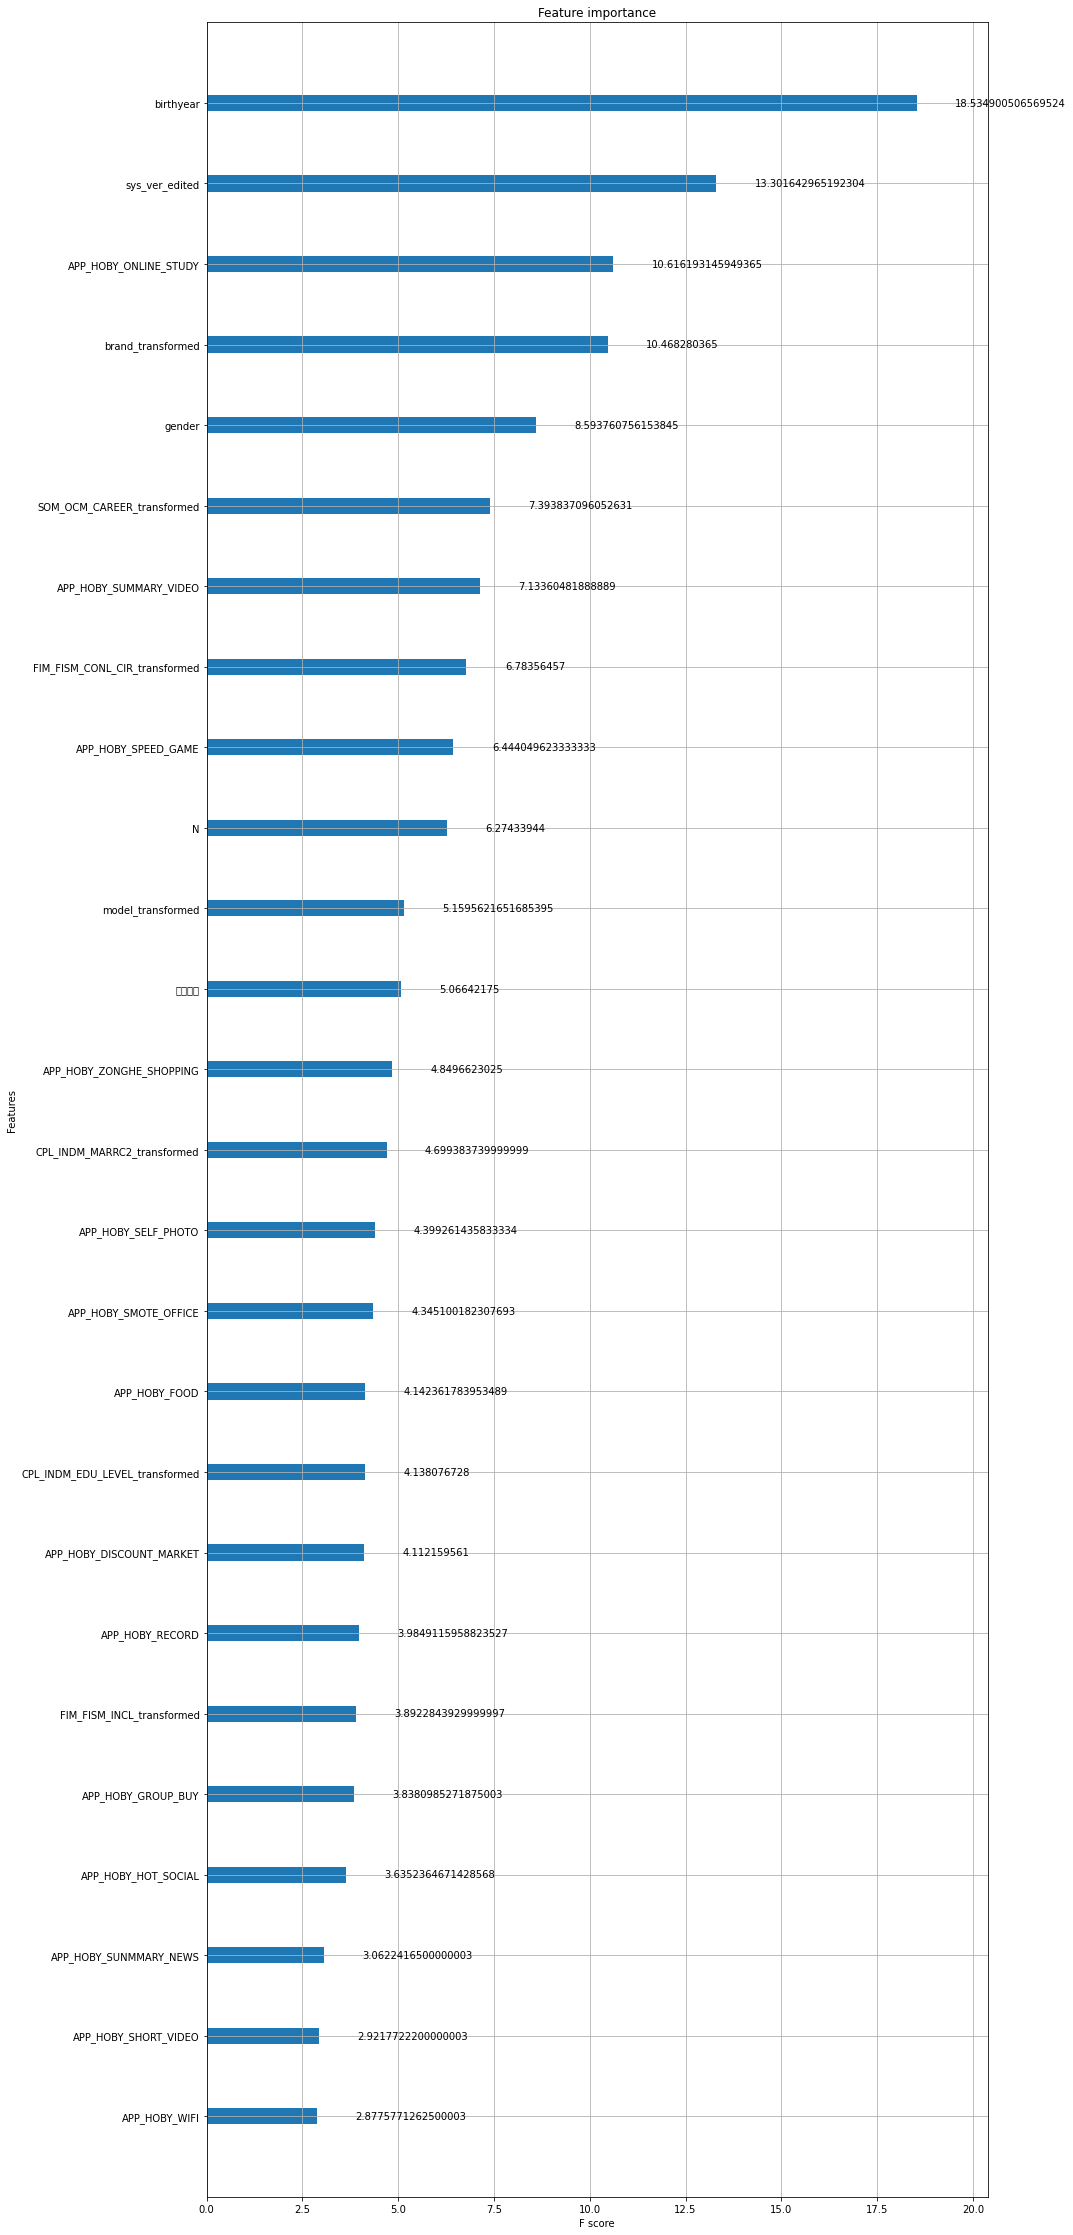

In [306]:
plt.rcParams["figure.figsize"] = (14, 40)
plot_importance(model,importance_type='gain')

In [385]:
col_drop_useless_feat=['gender',
             'birthyear',
             'SOM_OCM_CAREER_transformed',
             'CPL_INDM_EDU_LEVEL_transformed',
             'CPL_INDM_MARRC2_transformed',
             'FIM_FISM_INCL_transformed',
             'FIM_FISM_CONL_CIR_transformed',
#  'GBM_BHM_PURB_CONP_one_hot',
#  'GBM_BHM_PURB_PREF_transformed',
             'sys_ver_edited',
             'brand_transformed',
             'model_transformed'
             ]
# +
# [
# 'APP_HOBY_SHORT_VIDEO',
# 'APP_HOBY_SUMMARY_VIDEO' ,
# 'APP_HOBY_SELF_PHOTO' ,
# 'APP_HOBY_SUNMMARY_NEWS' ,
# 'APP_HOBY_SPEED_GAME',
# 'APP_HOBY_WIFI',
# 'APP_HOBY_FOOD',
# 'APP_HOBY_RECORD',
# 'APP_HOBY_HOT_SOCIAL' ,
# 'APP_HOBY_ONLINE_STUDY' ,
# 'APP_HOBY_ZONGHE_SHOPPING' ,
# 'APP_HOBY_DISCOUNT_MARKET' ,
# 'APP_HOBY_GROUP_BUY' ,
# 'APP_HOBY_SMOTE_OFFICE'
#                  ]

# col_drop_useless_feat.append('N')
# col_drop_useless_feat.append('品牌折扣')
# col_drop_useless_feat.remove('N')
# col_drop_useless_feat.remove('品牌折扣')

In [395]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import HuberRegressor, LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.kernel_ridge import KernelRidge
import xgboost as xgb
from xgboost import plot_importance, XGBClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

temp = train_df5

col_feat = col_drop_useless_feat
# col_feat.append('N')
# col_feat.append('品牌折扣')

col_ans = 'pref'

kf = KFold(n_splits=8,shuffle=True)
r0 = []
r1 = []
m0 = []
m1 = []
f = 0
# citys = list(temp.city_id.unique())
train_X,test_X,train_y,test_y =train_test_split(temp[col_feat],temp[col_ans],test_size=0.3)


# dtrain = xgb.DMatrix(train_X,test_X)
num_rounds = 100

model = XGBClassifier(
                     booster= 'gbtree',
                    objective='binary:logistic',
                    gamma= 0.2349319866098618,
                    max_depth= 5,
#                         reg_lambda= 3,
                    subsample= 0.7769258669266205,
                    colsample_bytree= 0.8251518366190885,
                    min_child_weight= 1,
                    eta=0.013312868125031425,
                    seed=1000,
                    nthread= 4,
                    n_estimators=190,
#                     silent=0 

)


# dtest = xgb.DMatrix(train_y,test_y)
model.fit(train_X, train_y, eval_metric=["auc"],eval_set=[(test_X,test_y)],early_stopping_rounds=30,verbose=True)

pred = model.predict(test_X)
pred = [round(value) for value in pred]

accuracy = accuracy_score(test_y, pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# model=xgb.train(params, dtrain, num_rounds, [(dtest, 'eval'), (dtrain,'train')])


[0]	validation_0-auc:0.55056
Will train until validation_0-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.58527
[2]	validation_0-auc:0.59527
[3]	validation_0-auc:0.60327
[4]	validation_0-auc:0.60224
[5]	validation_0-auc:0.60192
[6]	validation_0-auc:0.60459
[7]	validation_0-auc:0.60695
[8]	validation_0-auc:0.60704
[9]	validation_0-auc:0.60889
[10]	validation_0-auc:0.60904
[11]	validation_0-auc:0.60880
[12]	validation_0-auc:0.60970
[13]	validation_0-auc:0.61030
[14]	validation_0-auc:0.61027
[15]	validation_0-auc:0.60984
[16]	validation_0-auc:0.61180
[17]	validation_0-auc:0.61171
[18]	validation_0-auc:0.61173
[19]	validation_0-auc:0.61123
[20]	validation_0-auc:0.61130
[21]	validation_0-auc:0.61196
[22]	validation_0-auc:0.61164
[23]	validation_0-auc:0.61180
[24]	validation_0-auc:0.61186
[25]	validation_0-auc:0.61185
[26]	validation_0-auc:0.61184
[27]	validation_0-auc:0.61191
[28]	validation_0-auc:0.61121
[29]	validation_0-auc:0.61180
[30]	validation_0-auc:0.61121
[31]	validation_

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

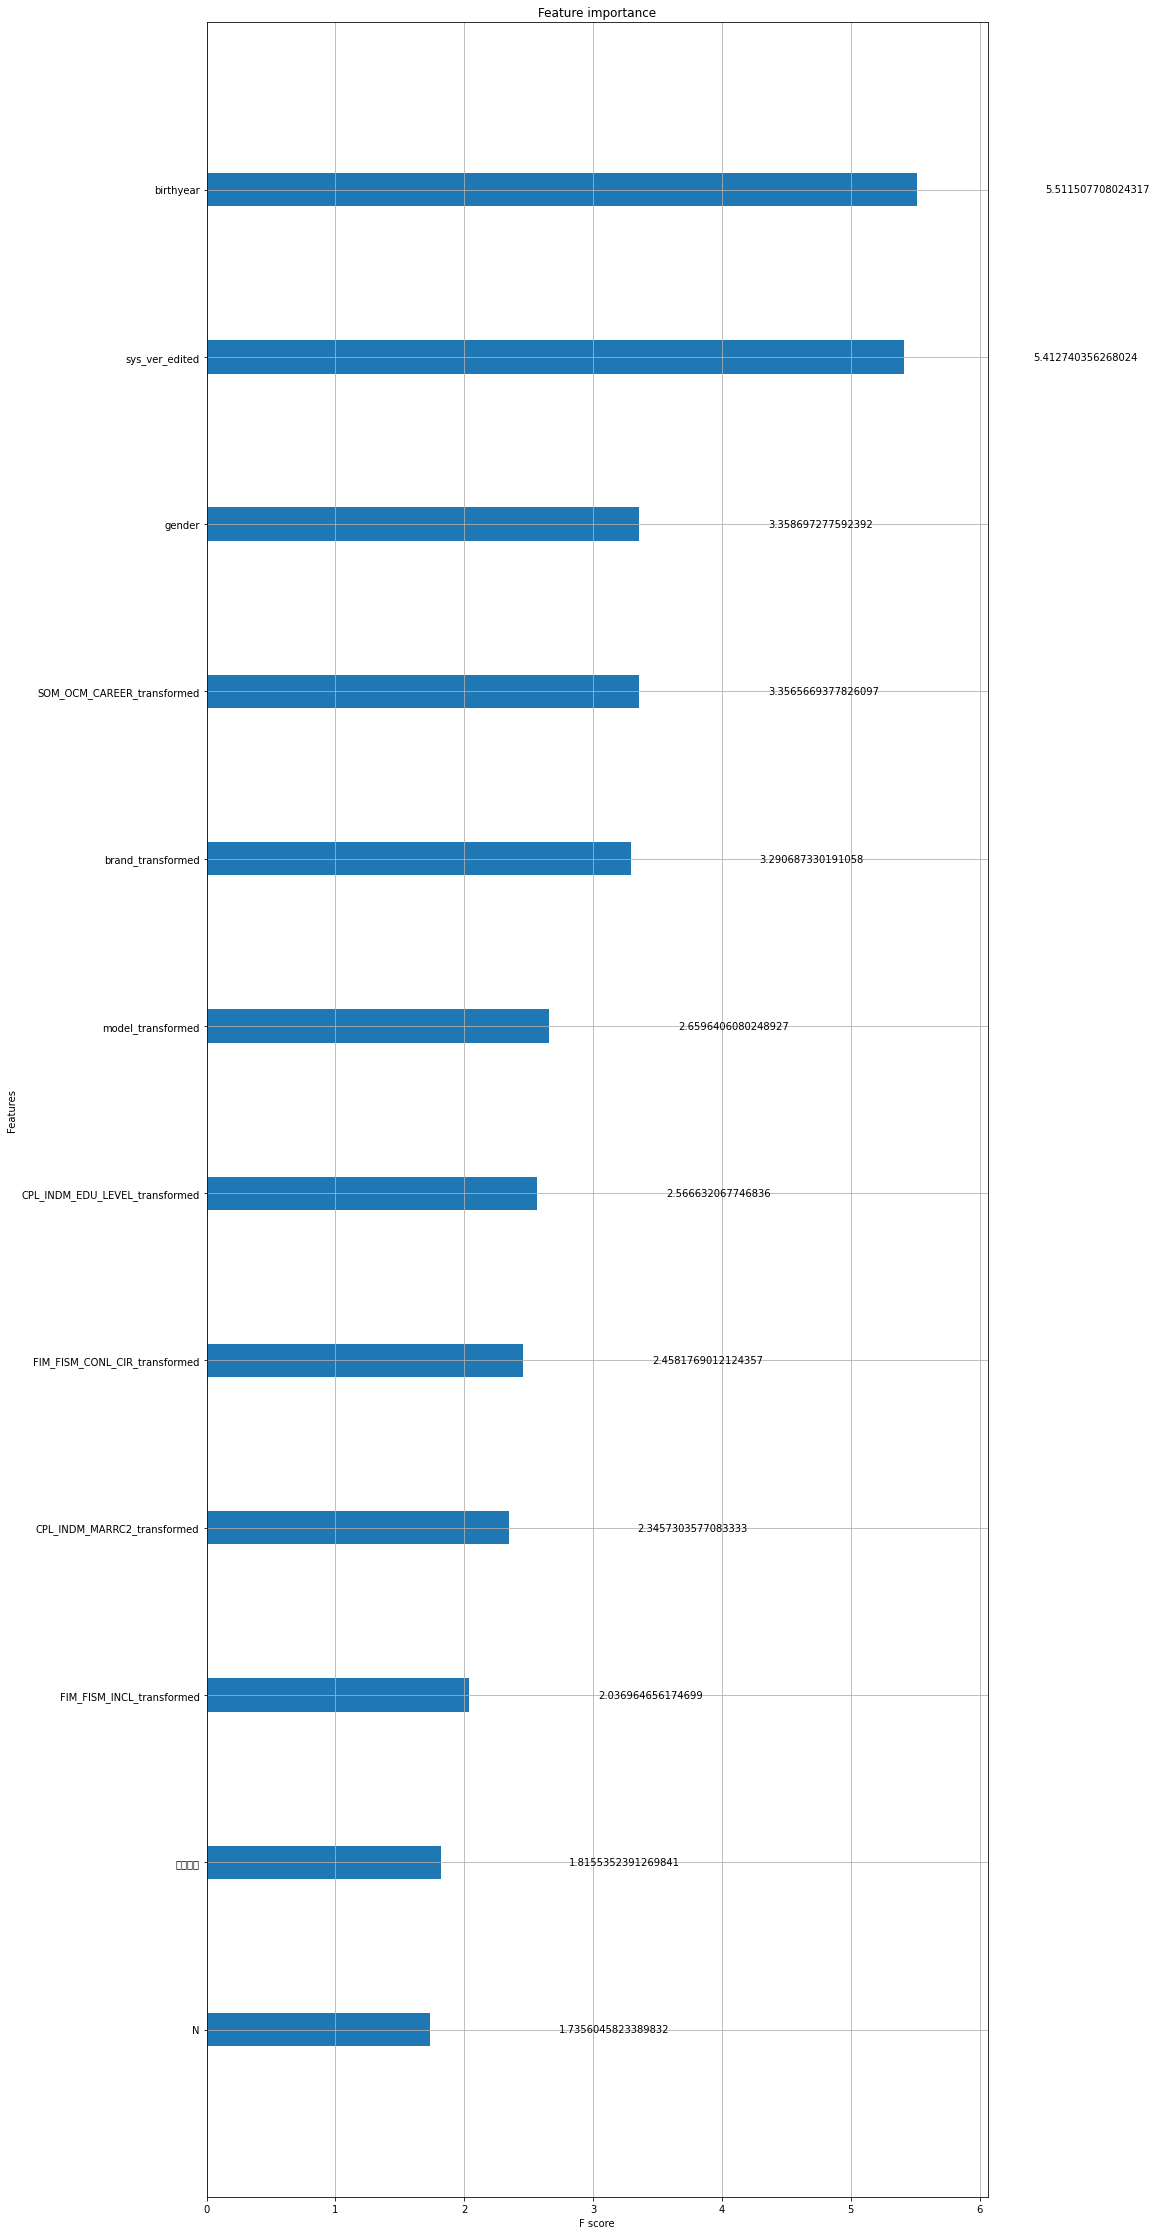

In [384]:
plt.rcParams["figure.figsize"] = (14, 40)
plot_importance(model,importance_type='gain')

In [392]:
train_df5['CPL_INDM_UNDERG'].value_counts()

0.0     21486
None     2235
1.0       889
Name: CPL_INDM_UNDERG, dtype: int64